In [1]:
import os
n_cores = 4
os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count={}'.format(n_cores)

from jax import config
config.update("jax_enable_x64", True)

import jax
import jax.numpy as jnp
import numpy as np
import pickle
from jax import jit, vmap, grad
import jax.random as random
key = random.PRNGKey(2022)
from jax.flatten_util import ravel_pytree

import matplotlib.pyplot as plt

from fem import plotmesh

# from jax.scipy.optimize import minimize
from scipy.optimize import minimize

In [2]:
def goh_P(lmbx, lmby, params):
    C10, k1, k2, kappa, theta = params
    # C10, k1, k2 = params
    # kappa = 0.1
    # theta = 0.0
    C10, k1, k2, kappa = jnp.exp(C10), jnp.exp(k1), jnp.exp(k2), jnp.exp(-kappa**2)*0.3
    # C10, k1, k2 = jnp.exp(C10), jnp.exp(k1), jnp.exp(k2)

    lmbz = 1.0/(lmbx*lmby)
    F = jnp.array([[lmbx, 0, 0],
                   [0, lmby, 0],
                   [0, 0, lmbz]])
    C = F.T @ F
    C2 = C @ C
    Cinv = jnp.linalg.inv(C)
    v0 = jnp.array([jnp.sin(theta), jnp.cos(theta), 0])
    V0 = jnp.outer(v0, v0)

    I1 = C[0,0] + C[1,1] + C[2,2]
    trC2 = C2[0,0] + C2[1,1] + C2[2,2]
    I2 = 0.5*(I1**2 - trC2)
    Iv = jnp.einsum('ij,ij',C,V0)

    E = kappa*(I1-3.0) + (1-3*kappa)*(Iv-1.0)
    E = jnp.maximum(E, 0.0)

    Psi1 = C10 + k1*kappa*E*jnp.exp(k2*E**2)
    Psiv = k1*(1-3*kappa)*E*jnp.exp(k2*E**2)
    Psi2 = 0.0
    Psiw = 0.0

    p = -C[2,2]*(2*Psi1 + 2*Psi2*(I1 - C[2,2]) + 2*Psiv*V0[2,2])
    S = p*Cinv + 2*Psi1*jnp.eye(3) + 2*Psi2*(I1*jnp.eye(3)-C) + 2*Psiv*V0

    P = F @ S
    return P
goh_P_vmap = vmap(goh_P, in_axes=(0,0,0))

In [3]:
with open('params/circ_s100_pre.npy', 'rb') as f:
    coord_2_strain_params, node_params, Lambda_params, mesh, elem_X, Fx, Fy, strains, \
                 bd_X, lmb_hist, sigma_hist_goh, F_hist_goh, node_x_hist_goh, t_hist = pickle.load(f)

       __       ___      ___   ___                _______  _______ .___  ___. 
      |  |     /   \     \  \ /  /               |   ____||   ____||   \/   | 
      |  |    /  ^  \     \  V  /      ______    |  |__   |  |__   |  \  /  | 
.--.  |  |   /  /_\  \     >   <      |______|   |   __|  |   __|  |  |\/|  | 
|  `--'  |  /  _____  \   /  .  \                |  |     |  |____ |  |  |  | 
 \______/  /__/     \__\ /__/ \__\               |__|     |_______||__|  |__| 
                                                                              



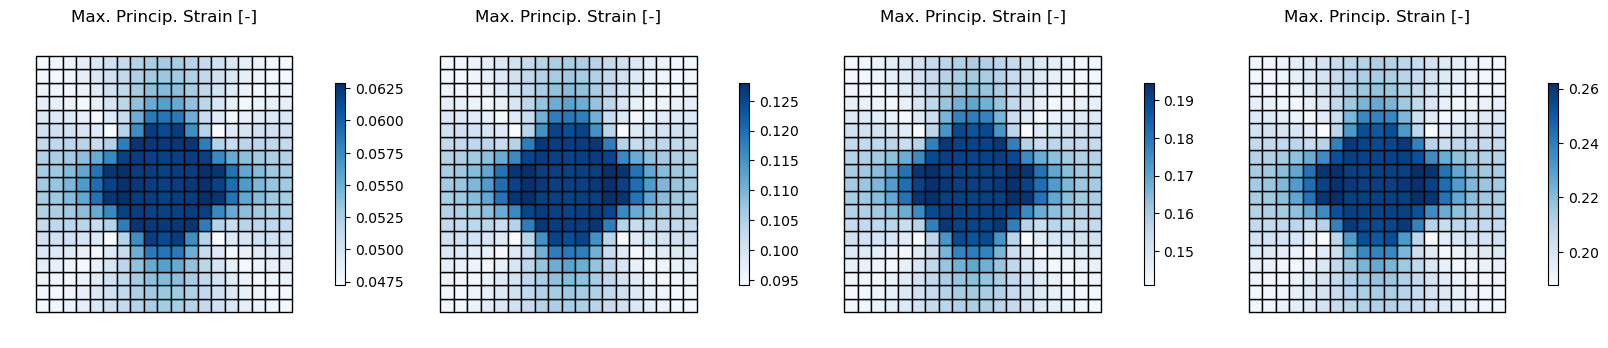

In [4]:
fig, axes = plt.subplots(1,4,figsize=(20,4))
strains = []
for t, node_x, F, sigma, ax in zip(t_hist, node_x_hist_goh, F_hist_goh, sigma_hist_goh, axes):
    eps_xx = F[:,0,0]-1.0
    eps_yy = F[:,1,1]-1.0

    mps = np.maximum(eps_xx, eps_yy)
    strains.append(np.array([t*np.ones_like(eps_xx), eps_xx, eps_yy]))

    plotmesh(mesh.cells, mesh.points, mps, title='Max. Princip. Strain [-]', ax=ax); 
strains = np.hstack(strains)

In [5]:
def VF1(x,y,h,w,p):
    U_x = x**p/w**p
    U_y = 0.0
    return jnp.stack([U_x,U_y]).T

def VF2(x,y,h,w,p):
    U_x = 0.0
    U_y = y**p/h**p
    return jnp.stack([U_x,U_y]).T

def VF3(x,y,h,w,p):
    U_x = jnp.sin(p*x*jnp.pi)*jnp.sin(p*y*jnp.pi)
    U_y = jnp.sin(p*x*jnp.pi)*jnp.sin(p*y*jnp.pi)
    return jnp.stack([U_x,U_y]).T

def VF4(x,y,h,w,p):
    U_x = jnp.sin(p*x*jnp.pi/w)**2*jnp.sin(p*y*jnp.pi/h)**2
    U_y = jnp.sin(p*x*jnp.pi/w)**2*jnp.sin(p*y*jnp.pi/h)**2
    return jnp.stack([U_x,U_y]).T

def VF5(x,y,h,w,p):
    U_x = 1.0-(x/w-1)**(2*p)
    U_y = 0.0
    return jnp.stack([U_x,U_y]).T

def VF6(x,y,h,w,p):
    U_x = 0.0
    U_y = 1.0-(y/h-1)**(2*p)
    return jnp.stack([U_x,U_y]).T

def VF_and_grad(VF, x, y, h, w, p):
    VF_dx = jax.jacfwd(VF, argnums=0)
    VF_dy = jax.jacfwd(VF, argnums=1)
    VF_grad = vmap(lambda x,y,h,w,p: jnp.stack([VF_dx(x,y,h,w,p), VF_dy(x,y,h,w,p)]).T, in_axes=(0,0,None,None,None))

    VF_vmap = vmap(VF, in_axes=(0,0,None,None,None))
    return VF_vmap(x,y,h,w,p), VF_grad(x,y,h,w,p)


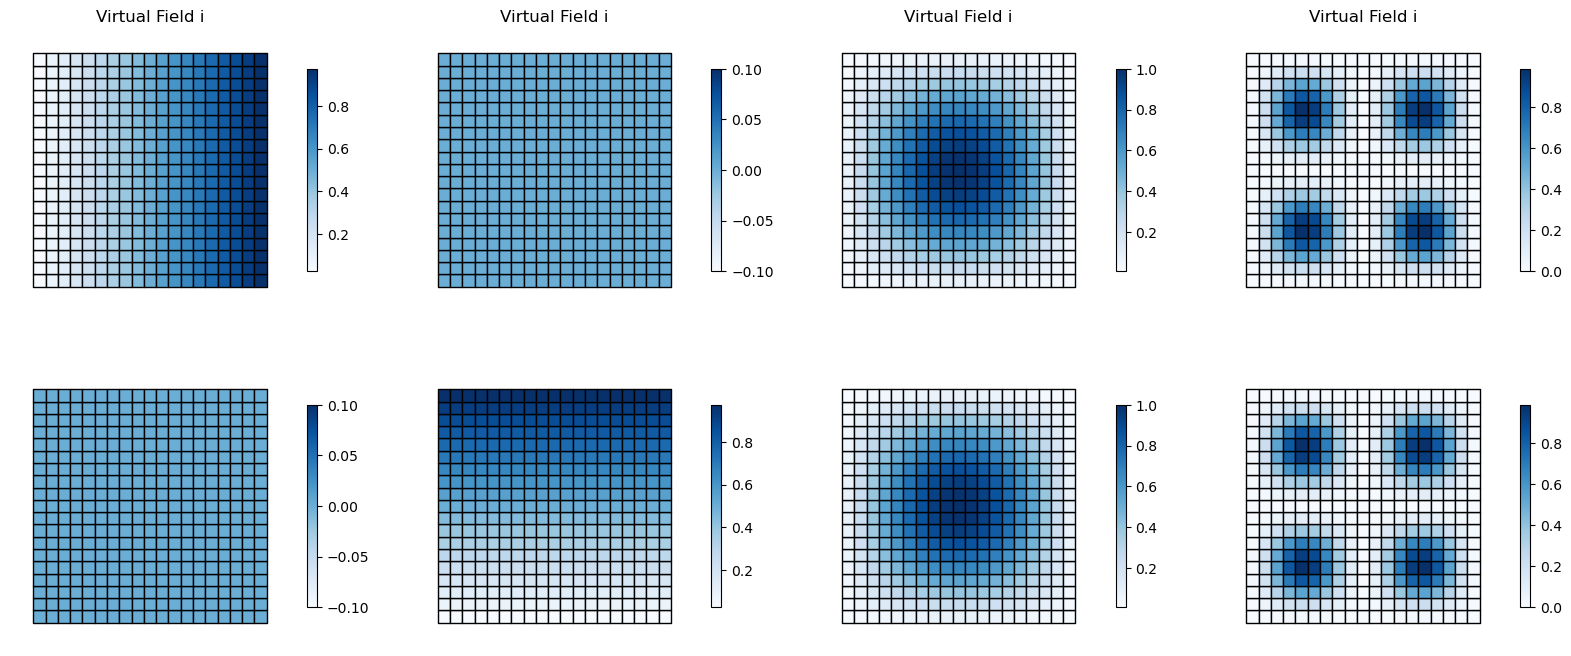

In [6]:
h = 1.0
w = 1.0
# VF_list = [VF1, VF1, VF2, VF2, VF3, VF4, VF5, VF6]
# p_list =  [1.0, 2.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0]
VF_list = [VF1, VF2, VF3, VF4]
p_list =  [1.0, 1.0, 1.0, 2.0]
x, y = elem_X.T
U, gradU = [], []
fig, axes = plt.subplots(2,len(VF_list),figsize=(len(VF_list)*5,8))
for ax, VF, p in zip(axes.T, VF_list, p_list):
    Ui, gradUi = VF_and_grad(VF, x,y,h,w,p)
    plotmesh(mesh.cells, mesh.points, Ui[:,0], title='Virtual Field i', ax=ax[0]); 
    plotmesh(mesh.cells, mesh.points, Ui[:,1], title=None, ax=ax[1]); 
    U.append(Ui)
    gradU.append(gradUi)
U, gradU = np.array(U), np.array(gradU)

In [7]:
# def GOH_PK1(lmbx, lmby, params):
#     C10, k1, k2, kappa, theta = params
#     C10, k1, k2, kappa = jnp.exp(C10), jnp.exp(k1), jnp.exp(k2), jnp.exp(-kappa**2)*0.3
#     #Kinematics
#     F_2D = jnp.array([[lmbx, 0.0],
#                       [0.0, lmby]])
#     C_2D = F_2D.T @ F_2D
#     Cinv_2D = jnp.linalg.inv(C_2D)
#     detC_2D = jnp.linalg.det(C_2D)
#     C33 = 1/detC_2D
#     C = jnp.array([  [C_2D[0,0], C_2D[0,1], 0],\
#                     [C_2D[1,0], C_2D[1,1], 0],\
#                     [0,         0,       C33]])
#     C2 = C @ C
#     Cinv = jnp.linalg.inv(C)
#     I1 = C[0,0] + C[1,1] + C[2,2]
#     trC2 = C2[0,0] + C2[1,1] + C2[2,2]
#     I2 = 0.5*(I1**2 - trC2)
#     v0 = jnp.array([ jnp.cos(theta), jnp.sin(theta), 0])
#     V0 = jnp.outer(v0, v0)
#     Iv = jnp.einsum('ij,ij',C,V0)


#     # Energy/Stress
#     E = kappa*(I1-3.0) + (1-3*kappa)*(Iv-1.0)
#     E = jnp.maximum(E, 0.0)

#     Psi1 = C10 + k1*kappa*E*jnp.exp(k2*E**2)
#     Psiv = k1*(1-3*kappa)*E*jnp.exp(k2*E**2)
#     Psi2 = 0.0

#     p = -C[2,2]*(2*Psi1 + 2*Psi2*(I1 - C[2,2]) + 2*Psiv*V0[2,2])
#     S = p*Cinv + 2*Psi1*jnp.eye(3) + 2*Psi2*(I1*jnp.eye(3)-C) + 2*Psiv*V0
#     S_2D = S[:2,:2]
#     P_2D = F_2D @ S_2D
#     return P_2D
# GOH_vmap = vmap(GOH_PK1, in_axes=(0,0,0))

In [8]:
with open('test.npy','rb') as f:
    C10, k1, k2, kappa, theta = pickle.load(f)
C10 = np.log(C10)
k1 = np.log(k1)
k2 = np.log(k2)
kappa = np.sqrt(-np.log(kappa/0.3))
params_gt = np.stack([C10,k1,k2,kappa,theta]).T

In [11]:
#These are roughly the means of the gt params:
C10 = -0.5
k1 = -2.0
k2 = -1.5
kappa = 1.0
theta = 0.0

# C10 = -3.0
# k1 = 0.0
# k2 = 0.0
# kappa = 0.2
# theta = 0.1
params = np.array([[C10, k1, k2, kappa, theta]])
# params = np.array([[C10, k1, k2]])
params = np.repeat(params, len(elem_X), axis=0)
params_ravel, unravel = ravel_pytree(params)
@jit
def obj_fn(params):
    loss = []
    for step in range(len(F_hist_goh)):
        lmbx = F_hist_goh[step,:,0,0]
        lmby = F_hist_goh[step,:,1,1]
        P = goh_P_vmap(lmbx, lmby, unravel(params))
        # P = node_P_vmap()
        P = P[:,:2,:2]
        W_int = []
        W_ext = []
        for i_vf in range(len(U)):
            W_int.append(jnp.einsum('ijk,ijk', P, gradU[i_vf]))

            idx_rgt_and_top = U.shape[1] - 1 #We use U such that U is constant at the boundary. Therefore sampling U at one point on the bd is enough.
            idx_lft_and_bot = 0
            W_ext_rgt_bd = U[i_vf, idx_rgt_and_top, 0]*Fx[step]*19 # + the non-constant component of U * Fy=0 because we assume no shear loads at the boundary, i.e. Fy|_rgt = 0.
            W_ext_top_bd = U[i_vf, idx_rgt_and_top, 1]*Fy[step]*19
            W_ext_lft_bd = U[i_vf, idx_lft_and_bot, 0]*Fx[step]*19
            W_ext_bot_bd = U[i_vf, idx_lft_and_bot, 1]*Fy[step]*19
            W_ext.append(W_ext_rgt_bd + W_ext_top_bd)
        W_int = jnp.array(W_int)
        W_ext = jnp.array(W_ext)
        loss.append(jnp.sum((W_int-W_ext)**2))
    
    return jnp.sum(jnp.array(loss))

In [12]:
sol = minimize(obj_fn, jac = grad(obj_fn), x0=params_ravel, method='CG', options={'gtol':10.0})
params = unravel(sol.x)
# FSC: Do multiple restarts

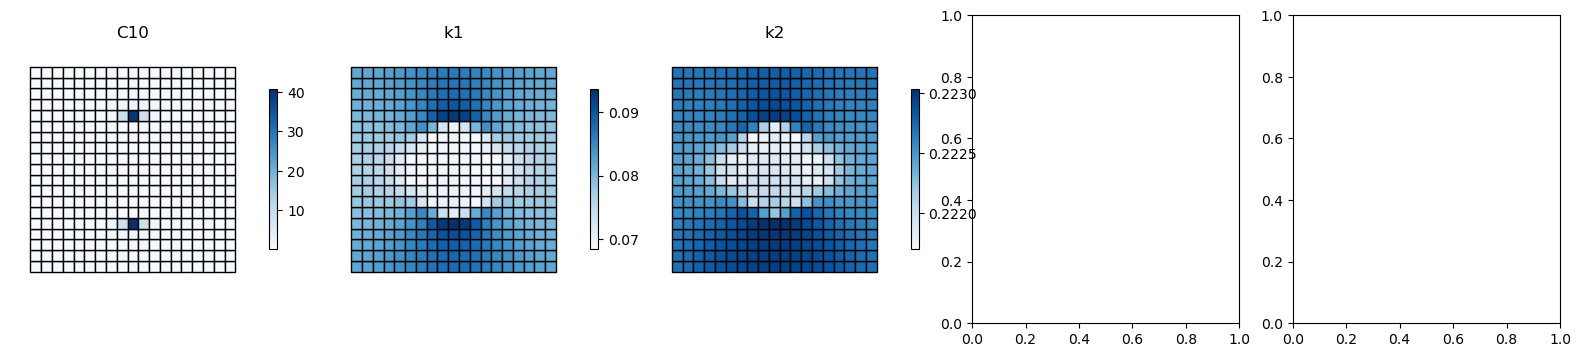

In [14]:
fig, ax = plt.subplots(1,5,figsize=(20,4)) 
plotmesh(mesh.cells, mesh.points, jnp.exp(params[:,0]), title='C10', ax=ax[0]); 
plotmesh(mesh.cells, mesh.points, jnp.exp(params[:,1]), title='k1', ax=ax[1]); 
plotmesh(mesh.cells, mesh.points, jnp.exp(params[:,2]), title='k2', ax=ax[2]); 
# plotmesh(mesh.cells, mesh.points, jnp.exp(-params[:,3]**2)*0.3, title='kappa', ax=ax[3]); 
# plotmesh(mesh.cells, mesh.points, params[:,4], title='theta', ax=ax[4]); 

In [15]:
np.savetxt('params/vfm_goh.npy', params)

In [16]:
from jax_fem.core import FEM
from jax_fem.solver import solver
from jax_fem.utils import save_sol
from jax_fem.generate_mesh import box_mesh, get_meshio_cell_type, Mesh, rectangle_mesh

In [17]:
params_vec = jnp.repeat(params.reshape([len(params),1,-1]), axis=1, repeats=4)

In [18]:
def GOH_PK1(u_grad, params, dim):
    # C10, k1, k2, kappa, theta = params
    C10, k1, k2 = params
    kappa = 0.1
    theta = 0.0
    # C10, k1, k2, kappa = jnp.exp(C10), jnp.exp(k1), jnp.exp(k2), jnp.exp(-kappa**2)*0.3
    C10, k1, k2 = jnp.exp(C10), jnp.exp(k1), jnp.exp(k2)
    #Kinematics
    F_2D = u_grad + jnp.eye(dim)
    C_2D = F_2D.T @ F_2D
    Cinv_2D = jnp.linalg.inv(C_2D)
    detC_2D = jnp.linalg.det(C_2D)
    C33 = 1/detC_2D
    C = jnp.array([  [C_2D[0,0], C_2D[0,1], 0],\
                    [C_2D[1,0], C_2D[1,1], 0],\
                    [0,         0,       C33]])
    C2 = C @ C
    Cinv = jnp.linalg.inv(C)
    I1 = C[0,0] + C[1,1] + C[2,2]
    trC2 = C2[0,0] + C2[1,1] + C2[2,2]
    I2 = 0.5*(I1**2 - trC2)
    v0 = jnp.array([ jnp.cos(theta), jnp.sin(theta), 0])
    V0 = jnp.outer(v0, v0)
    Iv = jnp.einsum('ij,ij',C,V0)


    # Energy/Stress
    E = kappa*(I1-3.0) + (1-3*kappa)*(Iv-1.0)
    E = jnp.maximum(E, 0.0)

    Psi1 = C10 + k1*kappa*E*jnp.exp(k2*E**2)
    Psiv = k1*(1-3*kappa)*E*jnp.exp(k2*E**2)
    Psi2 = 0.0

    p = -C[2,2]*(2*Psi1 + 2*Psi2*(I1 - C[2,2]) + 2*Psiv*V0[2,2])
    S = p*Cinv + 2*Psi1*jnp.eye(3) + 2*Psi2*(I1*jnp.eye(3)-C) + 2*Psiv*V0
    S_2D = S[:2,:2]
    P_2D = F_2D @ S_2D
    return P_2D
GOH_vmap = vmap(GOH_PK1, in_axes=(0,0,None))
def GOH_sigma(u_grad, params, dim):
    F_2D = u_grad + jnp.eye(dim)
    P_2D = GOH_PK1(u_grad, params, dim)
    return P_2D @ F_2D.T
GOH_sigma_vmap = vmap(GOH_sigma, in_axes=(0,0,None))
class HyperElasticity(FEM):
    def get_tensor_map(self):
        return lambda u_grad, params: GOH_PK1(u_grad, params, self.dim)
    
    def set_params(self, params_vec):
        self.internal_vars['laplace'] = [params_vec]

In [19]:
ele_type = 'QUAD4'
cell_type = get_meshio_cell_type(ele_type)

Nx, Ny = 19, 19
Lx, Ly = 1.0, 1.0
meshio_mesh = rectangle_mesh(Nx=Nx, Ny=Ny, domain_x=Lx, domain_y=Ly)
mesh = Mesh(meshio_mesh.points, meshio_mesh.cells_dict[cell_type])


# Functions to identify the boundary nodes
def bottom(point):
    return jnp.isclose(point[1], 0., atol=1e-5)
def left(point):
    return jnp.isclose(point[0], 0., atol=1e-5)
def top(point):
    return jnp.isclose(point[1], Ly, atol=1e-5)
def right(point):
    return jnp.isclose(point[0], Lx, atol=1e-5)
def bottom_left(point):
    return jnp.logical_and(jnp.logical_and(bottom(point), left(point)), jnp.isclose(point[2], 0., atol=1e-5))


# Functions to assign dirichlet BCs
def zero_dirichlet(point):
    return 0.
def lmbx_max_dirichlet(point, lmbx_max):
    return Lx*lmbx_max - 1.0
def lmby_max_dirichlet(point, lmby_max):
    return Ly*lmby_max - 1.0


lmb_hist = [1.05, 1.10, 1.15, 1.20]
n_elem = Nx*Ny
C10 = jnp.zeros(n_elem)
k1  = jnp.zeros(n_elem)
k2  = jnp.zeros(n_elem)
F_hist = []
node_x_hist = []
sigma_hist = []
for lmb_max in lmb_hist:
    dirichlet_bc_info = [
        [bottom,            left,           top,                                        right,                                  ],
        [1,                 0,              1,                                          0,                                      ],
        [zero_dirichlet,    zero_dirichlet, lambda p: lmby_max_dirichlet(p, lmb_max),   lambda p: lmbx_max_dirichlet(p, lmb_max)]
    ]
    problem = HyperElasticity(mesh,
                            vec=2,
                            dim=2,
                            ele_type=ele_type,
                            dirichlet_bc_info=dirichlet_bc_info)
    elem_X = problem.get_physical_quad_points().mean(1)

    problem.set_params(params_vec)


    node_x = solver(problem, use_petsc=True)
    u_grad = np.mean(problem.sol_to_grad(node_x), axis=1)
    F = u_grad + np.eye(2)
    sigma = GOH_sigma_vmap(u_grad, params_vec[:,0,:], 2)
    
    F_hist.append(F)
    node_x_hist.append(node_x)
    sigma_hist.append(sigma)
node_x_hist = np.array(node_x_hist)
F_hist = np.array(F_hist)
sigma_hist = np.array(sigma_hist)

[12-14 12:27:28][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[12-14 12:27:28][DEBUG] jax_fem: ele_type = QUAD4, quad_points.shape = (num_quads, dim) = (4, 2)
[12-14 12:27:28][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (4, 2, 2)
[12-14 12:27:29][DEBUG] jax_fem: Done pre-computations, took 0.37424373626708984 [s]
[12-14 12:27:29][INFO] jax_fem: Solving a problem with 361 cells, 400x2 = 800 dofs.
[12-14 12:27:29][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[12-14 12:27:29][DEBUG] jax_fem: Start timing
[12-14 12:27:29][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[12-14 12:27:30][DEBUG] jax_fem: Function split_and_compute_cell took 1.4250 seconds
[12-14 12:27:31][DEBUG] jax_fem: Creating sparse matrix with scipy...
[12-14 12:27:31][DEBUG] jax_fem: Linear guess solve...
[12-14 12:27:31][DEBUG] jax_fem: PETSc - Solving with ksp_type = bcgsl, pc = ilu
[12-14 12:27:31][DEBUG] jax_fem: PETSc

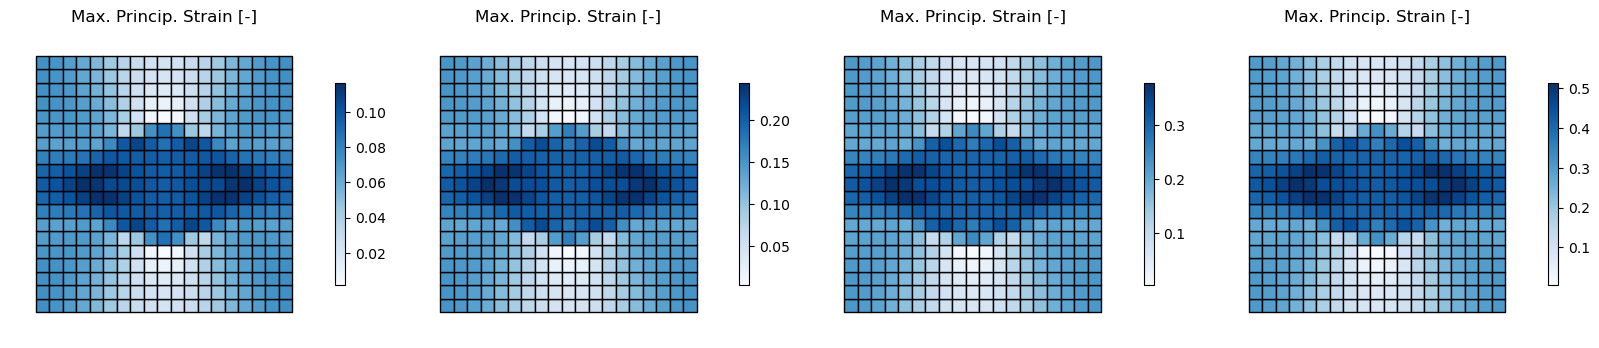

In [20]:
fig, axes = plt.subplots(1,4,figsize=(20,4))
strains = []
t_hist = np.arange(len(lmb_hist))
for t, node_x, F, sigma, ax in zip(t_hist, node_x_hist, F_hist, sigma_hist, axes):
    eps_xx = F[:,0,0]-1.0
    eps_yy = F[:,1,1]-1.0

    mps = np.maximum(eps_xx, eps_yy)

    plotmesh(mesh.cells, mesh.points, mps, title='Max. Princip. Strain [-]', ax=ax); 